# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Model Evaluation & Feature Importance

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Explain how feature importance is calculated for decision trees
- Calculate feature importance manually
- Extract feature importance with scikit-learn
- Extend the calculation to ensemble models (RF, ET)

In [ ]:
# Add graphviz in the terminal; you will need this later.
# $ pip install graphviz

## Opening 
Today we will discuss feature importance for tree based models. When we build a machine learning model we are not only interested in pure prediction accuracy. More often than not we are building a model to get insights on what the relevant predictor variables are.

E.g. you have 1000 features to predict user retention.
Which features are relevant? Can you identify them? Can you build marketing strategies to address them?

## Feature importance for non-parametric models 

We previously discussed feature selection in the context of logistic regression. Logistic regression is a parametric model, which means that our hypothesis is described in terms of coefficients that we tune to improve the model's accuracy. In particular, since LR is a linear model, each parameter is associated to a specific feature. Thus, if the features are normalized, we can interpret the size of each coefficient to indicate the relative importance of that specific feature.

### Decision Trees
Tree based models are non-parametric, thus we don't have coefficients to tune like we did in linear models. We can however still ask which of the features are more important.

When training a tree, we can compute how much each feature decreases the weighted impurity by adding up all the impurity gains where such a feature is used to determine a split. In other words, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

### Demo: Feature importance in Decision Trees

Suppose you are working at a car company and you are tasked to identify which features drive the acceptability of a car. You have collected some data on several features including:

    - PRICE                  overall price
        - buying             buying price
        - maint              price of the maintenance
    - TECH                   technical characteristics
        - COMFORT            comfort
            - doors          number of doors
            - persons        capacity in terms of persons to carry
            - lug_boot       the size of the trunk
        - safety             estimated safety of the car

(This is the car dataset we used previously.) 

Feature values are:

    buying       v-high, high, med, low
    maint        v-high, high, med, low
    doors        2, 3, 4, 5-more
    persons      2, 4, more
    lug_boot     small, med, big
    safety       low, med, high

Class Distribution (number of instances per class):

    class      N          N[%]
    -----------------------------
    unacc     1210     (70.023 %) 
    acc        384     (22.222 %) 
    good        69     ( 3.993 %) 
    v-good      65     ( 3.762 %) 

#### First of all let's load it and map it to binary features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
df = pd.read_csv('../6.05-random-forests/assets/datasets/car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


This time we will encode the features using a One Hot encoding scheme, i.e. we will consider them as categorical variables.

Since Scikit-Learn doesn't understand strings, but only numbers we will also need to map the labels to numbers. We can use the `LabelEncoder` we've encountered other times.

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['acceptability'])
X = pd.get_dummies(df.drop('acceptability', axis=1))

In [3]:
y

array([2, 2, 2, ..., 2, 1, 3])

In [4]:
X

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
5,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0
6,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
7,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
8,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
9,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,1,0


Let's train a decision tree on the whole dataset (ignore overfitting for the moment). Let's also artificially constrain the tree to be small so that we can visualize it.

In [6]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)

dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Next, let's visualize the tree:

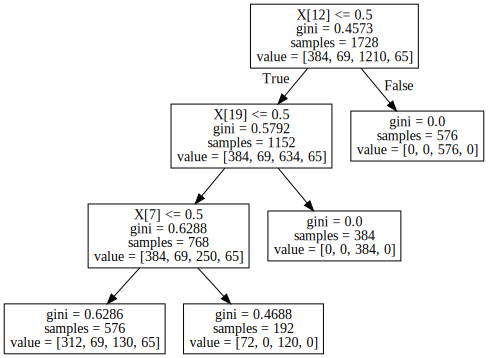

In [7]:
import graphviz

export_graphviz(dt, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [14]:
df[df['persons']=='2'].acceptability.value_counts()

unacc    576
Name: acceptability, dtype: int64

The first choice involves `person_2`. If the car only takes 2 people (`person_2` == 1) then the condition (our target class) is unacceptable. This happens in 33% of the cases. Note that the leaf under the `False` branch is 100% pure, and therefore its Gini measure is 0.0.

On the other hand, if the car can hold more than 2 people, we will need to consider other choices. For example if the car is unsafe, then it's also unacceptable. And so on.

If the target is a classification taking values $1, \ldots, K-1, K$. If node $m$ represents a region $R_m$ with $N_m$ observations, the proportion of class $k$ observations in node $m$ can be written as:
$$
        C_k = \frac{1}{N_m} \sum_{x_i\in R_m} I(y_i = k)
$$
The Gini Index is then defined as:
$$
        \text{Gini}= \sum_{k=1}^{K} C_k (1 - C_k)
              = 1 - \sum_{k=1}^{K} C_k^2
$$

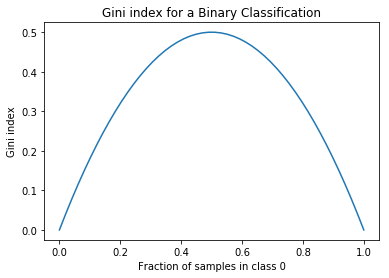

In [15]:
C0 = np.linspace(0,1)
C1 = 1.0 - C0

gini = 1 - C0**2 - C1**2

plt.plot(C0, gini)
plt.title('Gini index for a Binary Classification')
plt.xlabel('Fraction of samples in class 0')
plt.ylabel('Gini index')

Let's verify the calculation of the Gini index:

In [16]:
root_node_values = [0.22, 0.04, 0.7, 0.04] ## Proportion of results from root node.

def gini(values):
    tot = 0.0
    for val in values:
        tot += val ** 2
    
    return 1.0 - tot

gini(root_node_values)

0.45840000000000003

Great, now we are ready to look at feature importances in our tree:

In [17]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

## look at the gini index at the parent node
## subtract the weighted indicies of the children nodes
## want average 

,importance
safety_low,0.545239
persons_2,0.363493
maint_vhigh,0.091268
buying_high,0.000000
doors_5more,0.000000


Importance will be 

$$Importance = Gini(parent) - \sum_k C_k\cdot Gini(child_k)$$

where $C_k$ is the proportion of parent observations in class $k$.

**Note:** This is just the purity gain (information gain) from yesterday.

**Check:** How could we go through and calculate this ourselves?

## Guided Practice: Feature importance in Ensemble models

Scikit Learn implements feature importance for random forest and extra trees methods.

Let's train one of each of these and investigate the feature importance:

- Random Forest
- Extra Trees

In [18]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X, y)
et.fit(X,y)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Random forest exposes the feature importance and it calculates it as the average feature importance of the trees. Let's verify that.

(-1, 21)

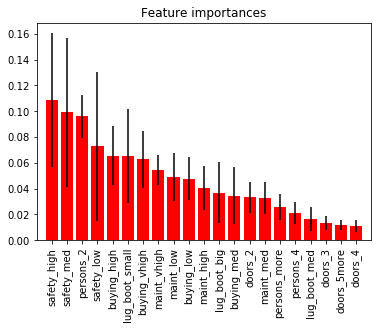

In [19]:
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

In [20]:
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

True

Now it's your turn: repeat the investigation for the extra trees model.

(-1, 21)

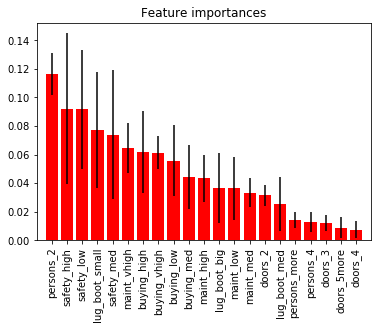

In [22]:
#all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = et.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 

std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

Finally let's compare the 3 models (re-init Decision Tree):

,dt_importance,rf_importance,et_importance
safety_high,0.072280,0.108559,0.092159
safety_med,0.028619,0.099246,0.073849
persons_2,0.155542,0.095896,0.116401
safety_low,0.233312,0.072955,0.091681
buying_high,0.026380,0.065623,0.061841


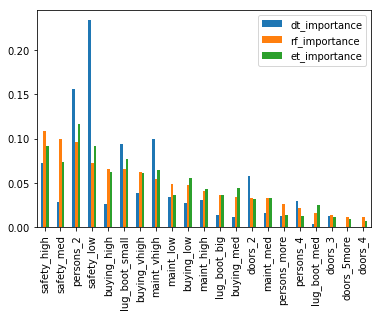

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar')
importances.head()

### ADDITIONAL RESOURCES

- [Gini Importance](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp)
- [DT Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Feature Importance in Sklearn Blog](http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/)
- [Plot Feature Importances example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- [Selecting good features](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)